## 数据清理与特征工程

### 1. 处理movie_item

载入包文件

In [156]:
import pandas as pd
import numpy as np
import json

载入数据

In [157]:
# 载入电影数据
data_item = pd.read_json('../douban_movie/data/movie_item.json', lines=True)
print('电影数目：' ,data_item.shape[0])

data_item['movie_id'] = data_item['movie_id'].apply(lambda x: int(x[0][3:]))  # [电影-1300267] -> int(1300267)
data_item['comment_num'] = data_item['comment_num'].apply(lambda x: int(x[2:-1]))  # 全部 62309 条 -> int(62309)
data_item['question_num'] = data_item['question_num'].apply(lambda x: int(x[2:-1]))  # 全部23个 -> int(23)
data_item['rating_num'] = data_item['rating_num'].apply(lambda x: float(x[0]))   # [9.2] -> float(9.2)
data_item['rating_per_stars1'] = data_item['rating_per_stars1'].apply(lambda x: float(x[:-1]))   # 0.1% -> float(0.1)
data_item['rating_per_stars2'] = data_item['rating_per_stars2'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars3'] = data_item['rating_per_stars3'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars4'] = data_item['rating_per_stars4'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars5'] = data_item['rating_per_stars5'].apply(lambda x: float(x[:-1]))
data_item['release_date'] = data_item['release_date'].apply(lambda x: int(x[0][1:-1]))  # [(1939)] -> int(1939)
data_item['vote_num'] = data_item['vote_num'].apply(lambda x: int(x[0]))   # [272357] -> int(272357)
data_item['movie_title'] = data_item['movie_title'].apply(lambda x: (x[0]))

# [238分钟] -> 238
data_item.loc[15,'runtime'] = ['80分钟']
pattern = '\d+'
import re
data_item['runtime'] = data_item['runtime'].apply(lambda x: (x[0]))
data_item['runtime'] = data_item['runtime'].str.findall(pattern,flags=re.IGNORECASE).apply(lambda x: int(x[0]))

def Intro(introduces):
    Intro_ = ''
    for intro in introduces:
        intro = intro.strip()
        Intro_ += intro
    return Intro_
data_item['intro'] = data_item.intro.apply(Intro)

电影数目： 246


In [3]:
#data_item[data_item.movie_id == 6146955]

In [4]:
data_item.head(1)

,comment_num,country,directedBy,genre,intro,language,movie_id,movie_title,question_num,rating_num,rating_per_stars1,rating_per_stars2,rating_per_stars3,rating_per_stars4,rating_per_stars5,release_date,runtime,starring,vote_num
0,62309,美国,"[维克多·弗莱明, 乔治·库克, 山姆·伍德]","[剧情, 爱情, 历史, 战争]",美国南北战争前夕，南方农场塔拉庄园的千金斯嘉丽（费雯·丽 Vivien Leigh 饰）爱上...,英语,1300267,乱世佳人 Gone with the Wind,23,9.2,0.1,0.3,5.5,27.0,67.1,1939,238,"[托马斯·米切尔, 芭芭拉·欧内尔, 费雯·丽, 伊夫林·凯耶斯, 安·卢瑟福德, 乔治·里...",272357


In [5]:
data_item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 0 to 245
Data columns (total 19 columns):
comment_num          246 non-null int64
country              246 non-null object
directedBy           246 non-null object
genre                246 non-null object
intro                246 non-null object
language             246 non-null object
movie_id             246 non-null int64
movie_title          246 non-null object
question_num         246 non-null int64
rating_num           246 non-null float64
rating_per_stars1    246 non-null float64
rating_per_stars2    246 non-null float64
rating_per_stars3    246 non-null float64
rating_per_stars4    246 non-null float64
rating_per_stars5    246 non-null float64
release_date         246 non-null int64
runtime              246 non-null int64
starring             246 non-null object
vote_num             246 non-null int64
dtypes: float64(6), int64(6), object(7)
memory usage: 38.4+ KB


In [6]:
# 总评分最高的前10部电影
data_item.sort_values('rating_num', ascending=False)[['movie_title','rating_num']].head(10)

,movie_title,rating_num
243,肖申克的救赎 The Shawshank Redemption,9.6
236,控方证人 Witness for the Prosecution,9.6
102,美丽人生 La vita è bella,9.5
98,霸王别姬,9.5
107,十二怒汉 12 Angry Men,9.4
103,阿甘正传 Forrest Gump,9.4
101,这个杀手不太冷 Léon,9.4
100,辛德勒的名单 Schindler's List,9.4
108,机器人总动员 WALL·E,9.3
120,海豚湾 The Cove,9.3


《肖申克的救赎》果然仍旧排在第一位，不过排在第二的《控方证人》确不在豆瓣Top250中排名靠前，看来豆瓣官方的排名是另有依据的。

接下来，将分别分析最受欢迎的电影类别genre、电影出品国家country、导演directedBy、演员starring、电影语言language、电影时长runtime和电影评价数vote_num。

首先，我们来定义三个函数以及电影类别和国别：


In [376]:
def column_expand(data, column, list_values):
    for cl in list_values:
        tt = data_item[column].apply(lambda x: str(x)).str.contains('\W'+cl+'\W')
        uu = data_item[column].apply(lambda x: str(x)).str.contains('^'+cl+'$')
        ee = data_item[column].apply(lambda x: str(x)).str.contains(cl+'\s')
        ff = data_item[column].apply(lambda x: str(x)).str.contains('\s'+cl)
        cl_ = tt | uu| ee | ff
        cl_ *= 1
        data['%s_%s' %(column ,cl)] = cl_
        
class_movie = ['剧情','爱情','喜剧','科幻','动作','悬疑','犯罪','恐怖','青春'
               ,'励志','战争','文艺','黑色幽默','传记','情色','暴力','音乐','家庭']
country_movie = ['大陆','美国','香港','台湾','日本','韩国','英国','法国','德国','意大利','西班牙','印度','泰国','俄罗斯'
 ,'伊朗','加拿大','澳大利亚','爱尔兰','瑞典','巴西','丹麦']

def get_values_list(data, column, sep=None):
    Language_values=[]
    def countLANG(Languages):
        for language in Languages:
            language = language.strip()
            if language in Language_values: 
                continue
            else:
                Language_values.append(language)
    if sep:
        pd.DataFrame(data[column].str.split(sep))[column].apply(countLANG);
    else:
        data[column].apply(countLANG);
    return Language_values

def Paiming(data, column, list_values):
    column_expand(data, column, list_values)
    df = pd.DataFrame( 
        {'数目':[data['%s_%s' %(column, p)].sum() for p in list_values]}
        , index=list_values).sort_values('数目', ascending=False)
    return df
# 列表匹配
#column_expand(data_item, 'genre', class_movie)
#column_expand(data_item,  'country', country_movie)
#column_expand(data_item,  'language', get_values_list(data_item, 'language', sep='/'))
#column_expand(data_item,  'starring', get_values_list(data_item, 'starring'))

In [377]:
# 最受欢迎的电影类别排名
Paiming(data_item, 'genre', class_movie)

,数目
剧情,191
爱情,62
喜剧,49
犯罪,45
动作,32
悬疑,29
家庭,27
科幻,25
战争,17
传记,12


In [9]:
# 最受欢迎的电影导演排名
temp = Paiming(data_item, 'directedBy', get_values_list(data_item, 'directedBy'))
print('共有%s位导演入选TOP250电影榜:' %len(temp))
temp.head(10)

共有196位导演入选TOP250电影榜:


,数目
克里斯托弗·诺兰,7
宫崎骏,7
史蒂文·斯皮尔伯格,6
王家卫,5
李安,4
大卫·芬奇,3
刘镇伟,3
理查德·林克莱特,3
朱塞佩·托纳多雷,3
詹姆斯·卡梅隆,3


In [10]:
# 最受欢迎的演员排名
temp = Paiming(data_item, 'starring', get_values_list(data_item, 'starring'))
print('共有%s位演员入选TOP250电影榜:' %len(temp))
temp.head(11)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


共有2317位演员入选TOP250电影榜:


,数目
张国荣,8
汤姆·汉克斯,7
布拉德·皮特,7
张曼玉,7
梁朝伟,7
伊桑·霍克,6
琼·艾伦,6
马特·达蒙,6
雨果·维文,6
莱昂纳多·迪卡普里奥,6


In [1697]:
# 最受欢迎的出品国家排名
temp = Paiming(data_item, 'country', country_movie)
print('共有%s个出品国家入选TOP250电影榜:' %len(temp))
temp.head(15)
temp

共有21个出品国家入选TOP250电影榜:


,数目
美国,141
英国,34
日本,29
法国,27
香港,26
德国,19
意大利,10
韩国,8
大陆,7
加拿大,7


In [1]:
def geod_world(df, title, legend = False):
    """
    temp0 = temp.reset_index()
    df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
                   ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
    """
    import geopandas as gp
    from matplotlib import pyplot as plt
    %matplotlib inline
    import matplotlib
    import seaborn as sns
    matplotlib.rc('figure', figsize = (14, 7))
    matplotlib.rc('font', size = 14)
    matplotlib.rc('axes', grid = False)
    matplotlib.rc('axes', facecolor = 'white')

    world_geod = gp.GeoDataFrame.from_file('./world_countries_shp/World_countries_shp.shp')
    data_geod = gp.GeoDataFrame(df)   # 转换格式
    da_merge = world_geod.merge(data_geod, on = 'NAME', how = 'left') # 合并
    sum(np.isnan(da_merge['NUM'])) # 
    da_merge['NUM'][np.isnan(da_merge['NUM'])] = 14.0#填充缺失数据
    da_merge.plot('NUM', k = 20, cmap = plt.cm.Blues,alpha= 1,legend = legend)
    plt.title(title, fontsize=15)#设置图形标题
    plt.gca().xaxis.set_major_locator(plt.NullLocator())#去掉x轴刻度
    plt.gca().yaxis.set_major_locator(plt.NullLocator())#去年y轴刻度

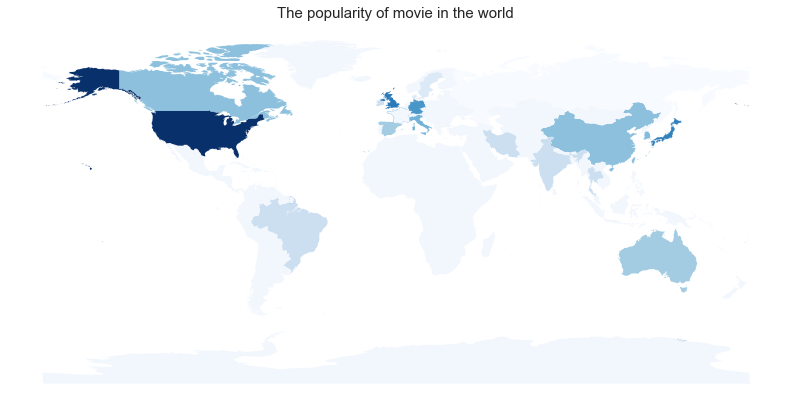

In [1708]:
country_dict = {'大陆':'China','美国':'United States','香港':'Hong Kong','台湾':'Taiwan, Province of China'
                 ,'日本':'Japan','韩国':'Korea, Republic of','英国':'United Kingdom','法国':'France','德国':'Germany'
                 ,'意大利':'Italy','西班牙':'Spain','印度':'India','泰国':'Thailand','俄罗斯':'Russian Federation'
                 ,'伊朗':'Iran','加拿大':'Canada','澳大利亚':'Australia','爱尔兰':'Ireland','瑞典':'Sweden'
                 ,'巴西':'Brazil','丹麦':'Denmark'}

temp0 = temp.reset_index()
df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
                   ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
geod_world(df, 'The popularity of movie in the world ')

In [15]:
# 最受欢迎的语言排名
temp = Paiming(data_item, 'language', get_values_list(data_item, 'language', sep='/'))
print('共有%s种语言入选TOP250电影榜:' %len(temp))
temp.head(15)

共有60种语言入选TOP250电影榜:


,数目
英语,170
法语,41
日语,37
汉语普通话,33
德语,25
粤语,24
意大利语,19
西班牙语,15
俄语,12
拉丁语,8


In [16]:
# 电影时长的排名
data_item.sort_values('runtime', ascending=False)[['movie_title','runtime']].head(10)

,movie_title,runtime
0,乱世佳人 Gone with the Wind,238
221,牯岭街少年杀人事件 牯嶺街少年殺人事件,237
235,美国往事 Once Upon a Time in America,229
199,教父2 The Godfather: Part Ⅱ,202
110,指环王3：王者无敌 The Lord of the Rings: The Return of...,201
100,辛德勒的名单 Schindler's List,195
104,泰坦尼克号 Titanic,194
230,绿里奇迹 The Green Mile,189
11,与狼共舞 Dances with Wolves,181
210,指环王2：双塔奇兵 The Lord of the Rings: The Two Towers,179


In [17]:
# 电影投票数的排名
data_item.sort_values('vote_num', ascending=False)[['movie_title','vote_num']].head(10)

,movie_title,vote_num
243,肖申克的救赎 The Shawshank Redemption,877684
101,这个杀手不太冷 Léon,838853
105,盗梦空间 Inception,766735
103,阿甘正传 Forrest Gump,714946
28,三傻大闹宝莱坞 3 Idiots,676928
106,千与千寻 千と千尋の神隠し,666166
104,泰坦尼克号 Titanic,657294
98,霸王别姬,631204
171,让子弹飞,612443
26,海上钢琴师 La leggenda del pianista sull'oceano,601595


In [18]:
# 电影评价数的排名
data_item.sort_values('comment_num', ascending=False)[['movie_title','comment_num']].head(10)

,movie_title,comment_num
243,肖申克的救赎 The Shawshank Redemption,206334
105,盗梦空间 Inception,201260
113,少年派的奇幻漂流 Life of Pi,197790
28,三傻大闹宝莱坞 3 Idiots,192686
101,这个杀手不太冷 Léon,192324
83,疯狂动物城 Zootopia,182765
109,怦然心动 Flipped,178532
111,星际穿越 Interstellar,176341
98,霸王别姬,167573
171,让子弹飞,155386


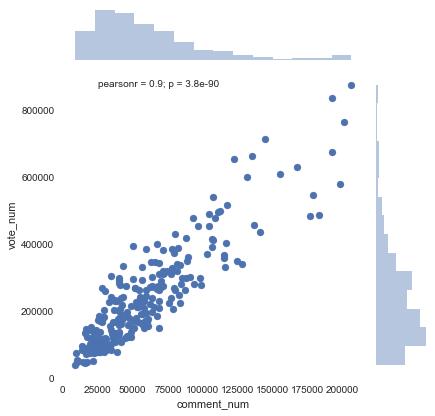

In [19]:
sns.jointplot(x="comment_num", y="vote_num", data=data_item)

In [20]:
# 电影问题数的排名
data_item.sort_values('question_num', ascending=False)[['movie_title','question_num']].head(10)

,movie_title,question_num
111,星际穿越 Interstellar,1215
196,消失的爱人 Gone Girl,282
83,疯狂动物城 Zootopia,264
19,彗星来的那一夜 Coherence,200
161,心迷宫,184
163,超能陆战队 Big Hero 6,142
172,布达佩斯大饭店 The Grand Budapest Hotel,135
224,爆裂鼓手 Whiplash,133
223,恐怖游轮 Triangle,119
231,再次出发之纽约遇见你 Begin Again,116


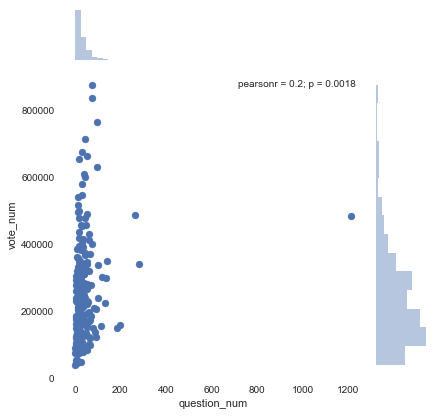

In [21]:
sns.jointplot(x="question_num", y="vote_num", data=data_item)

In [2]:
# 根据电影发布时间的规律
def plot2y(x_data, x_label, type1, y1_data, y1_color, y1_label, type2, y2_data, y2_color, y2_label, title):
    _, ax1 = plt.subplots()
    
    if type1 == 'hist':
        ax1.hist(x_data, histtype='stepfilled', bins=200, color = y1_color)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('symlog')
        ax1.set_title(title)

    elif type1 == 'plot':
        ax1.plot(x_data, y1_data, color = y1_color)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('linear')
        ax1.set_title(title)
        
    elif type1 == 'scatter':
        ax1.scatter(x_data, y1_data, color = y1_color, s = 10, alpha = 0.75)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('symlog')
        ax1.set_title(title)
        
    if type2 == 'bar':
        ax2 = ax1.twinx()
        ax2.bar(x_data, y2_data, color = y2_color, alpha = 0.75)
        ax2.set_ylabel(y2_label, color = y2_color)
        ax2.set_yscale('linear')
        ax2.spines['right'].set_visible(True)
        
    elif type2 == 'scatter':
        ax2 = ax1.twinx()
        ax2.scatter(x_data, y2_data, color = y2_color, s = 10, alpha = 0.75)
        ax2.set_ylabel(y2_label, color = y2_color)
        ax2.set_yscale('linear')
        ax2.spines['right'].set_visible(True)

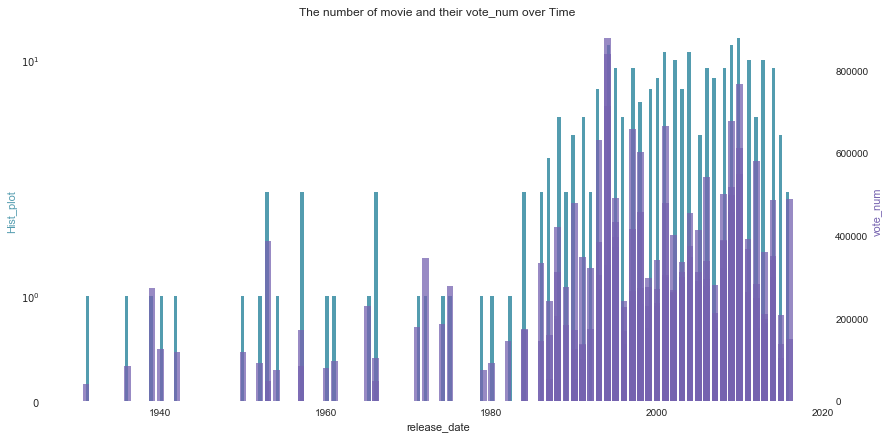

In [22]:
plot2y(x_data = data_item.release_date
           , x_label = 'release_date'
           , type1 = 'hist'
           , y1_data = data_item.vote_num #(无效果)
           , y1_color = '#539caf'
           , y1_label = 'Hist_plot'
           , type2 = 'bar'
           , y2_data = data_item.vote_num
           , y2_color = '#7663b0'
           , y2_label = 'vote_num'
           , title = 'The number of movie and their vote_num over Time')

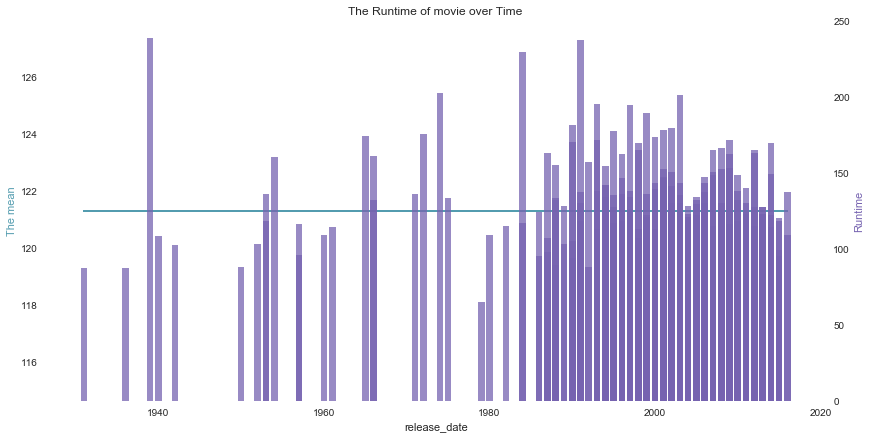

In [23]:
plot2y(x_data = data_item.release_date
           , x_label = 'release_date'
           , type1 = 'plot'
           , y1_data = data_item.runtime.apply(lambda x : data_item.runtime.mean())
           , y1_color = '#539caf'
           , y1_label = 'The mean'
           , type2 = 'bar'
           , y2_data = data_item.runtime
           , y2_color = '#7663b0'
           , y2_label = 'Runtime'
           , title = 'The Runtime of movie over Time')

In [ ]:
# 1～5星级投票的百分比

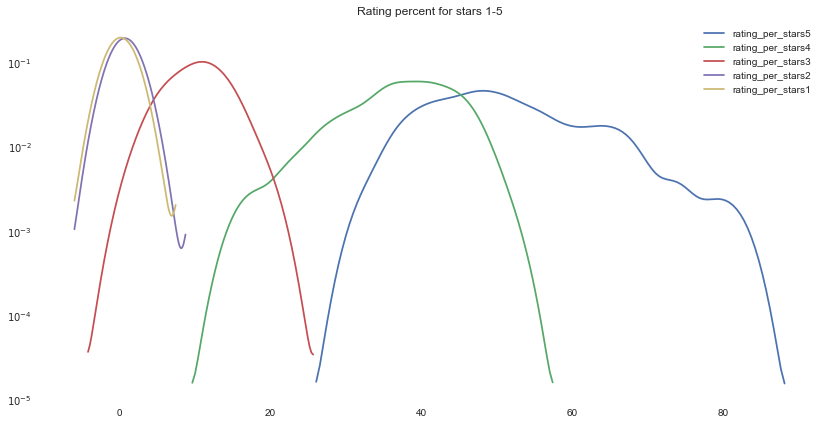

In [24]:
sns.kdeplot(data_item.rating_per_stars5, bw=2)
sns.kdeplot(data_item.rating_per_stars4, bw=2)
sns.kdeplot(data_item.rating_per_stars3, bw=2)
sns.kdeplot(data_item.rating_per_stars2, bw=2)
sns.kdeplot(data_item.rating_per_stars1, bw=2)
plt.yscale('log')
plt.title('Rating percent for stars 1-5')

In [1709]:
# 电影简介的情感分析

In [26]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy as np
import codecs
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(10.0,5.0)
from wordcloud import WordCloud # 词云包

In [27]:
# 导入、分词、去停用词
def lcut(Intro_movie):
    segment=[]
    segs = jieba.lcut(Intro_movie) # jiaba.lcut()   
    for seg in segs:
        if len(seg)>1 and seg!='\r\n':
            segment.append(seg)
    return segment

def dropstopword(segment):
    # 去停用词
    words_df = pd.DataFrame({'segment':segment})
    stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
    #stopwords.head()
    return words_df[~words_df.segment.isin(stopwords.stopword)].segment.values.tolist()

In [28]:
# 基于TextRank算法的关键词抽取(仅动词和动名词)
import jieba.analyse as analyse

data_item['keywords'] = data_item.intro.apply(lcut)\
                .apply(dropstopword)\
                .apply(lambda x : " ".join(x))\
                .apply(lambda x:" ".join(analyse.textrank(x, topK=8, withWeight=False, allowPOS=('n','ns','vn', 'v'))))
data_item.sort_values('rating_num', ascending=False)[['movie_title','keywords']].head(10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/jieba.cache
Loading model cost 1.582 seconds.
Prefix dict has been built succesfully.


,movie_title,keywords
243,肖申克的救赎 The Shawshank Redemption,监狱 希望 本片 惩罚 牢狱 管理层 接近 杀害
236,控方证人 Witness for the Prosecution,律师 嫌疑犯 遗嘱 警方 护士 爵士 刑案 同名
102,美丽人生 La vita è bella,儿子 圭多 法西斯 早安 公主 政权 游戏 妻子
98,霸王别姬,人生 程蝶衣 关系 风云 升级 变迁 本质 情仇
107,十二怒汉 12 Angry Men,陪审员 有罪 陪审团 被告 父亲 过程 证人 涉嫌
103,阿甘正传 Forrest Gump,妈妈 外交 美国 性格 坚强 至爱 离别 思念
101,这个杀手不太冷 Léon,女孩 邻居家 杀害 警方 缉毒 混杂着 暂避 救回
100,辛德勒的名单 Schindler's List,统治 工厂 德国 屠杀 军官 贿赂 拯救 出众
108,机器人总动员 WALL·E,地球 机器人 漫长 垃圾 公司 生活 喜欢 飞船
120,海豚湾 The Cove,海豚 拯救 太地 渔民 渔村 县太地 景色 理查德


### 2. 处理movie_comment

In [234]:
import pandas as pd
import numpy as np
import json
# 短评数据
movie_comment_file = ['../douban_movie/data/movie_comment%s.json' %j for j in [ i for i in range(20,220,20)] +[225,250]]
com = []
for f in movie_comment_file:
    lines = open(f, 'rb').readlines()
    com.extend([json.loads(elem.decode("utf-8")) for elem in lines])
data_com = pd.DataFrame(com)
data_com['movie_id'] = data_com['movie_id'].apply(lambda x: int(x[0][5:]))
data_com['content'] = data_com.content.apply(lambda x: x[0].strip())
data_com['people'] = data_com.people.apply(lambda x: x.strip())
data_com['people'] = data_com.people_url.apply(lambda x: x[30:-1])
data_com['useful_num'] = data_com.useful_num.apply(lambda x: int(x))
def regular_nonstar(x):
    if x == 'comment-time':
        return 'allstar00 rating'
    else:
        return x
data_com['star'] = data_com.star.apply(regular_nonstar).apply(lambda x: int(x[7]))
data_com['time'] = pd.to_datetime(data_com.time.apply(lambda x: x[0]))
print('获取的总短评数：' ,data_com.shape[0])

获取的总短评数： 249560


In [235]:
data_com = data_com[~data_com.comment_id.duplicated()]
print('去重后的总短评数：' ,data_com.shape[0])

people_url = data_com.people_url.unique().tolist()
np.savetxt('../douban_movie/bin/people_url.out', people_url, fmt='%s')
urllist = np.loadtxt('../douban_movie/bin/people_url.out', dtype='|S').tolist()
len(urllist)

去重后的总短评数： 249512


38599

In [26]:
data_com = data_com.drop(['URL','people_url'], axis=1)
data_com['label'] = (data_com.star >=3) *1

In [27]:
data_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249512 entries, 0 to 249559
Data columns (total 8 columns):
comment_id    249512 non-null int64
content       249512 non-null object
movie_id      249512 non-null int64
people        249512 non-null object
star          249512 non-null int64
time          249512 non-null datetime64[ns]
useful_num    249512 non-null int64
label         249512 non-null int64
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 17.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 249512 entries, 0 to 249559
Data columns (total 8 columns):
comment_id    249512 non-null int64
content       249512 non-null object
movie_id      249512 non-null int64
people        249512 non-null object
star          249512 non-null int64
time          249512 non-null datetime64[ns]
useful_num    249512 non-null int64
label         249512 non-null int64
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 17.1+ MB


In [11]:
data_com.head(2)

,comment_id,content,movie_id,people,star,time,useful_num,label
0,2050003,不需要女主角的好电影,1292052,kingfish,5,2006-03-22 12:38:09,11314,1
1,32514679,恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》,1292052,如小果,5,2008-02-27 21:43:23,7277,1


,comment_id,content,movie_id,people,star,time,useful_num,label
0,2050003,不需要女主角的好电影,1292052,kingfish,5,2006-03-22 12:38:09,11314,1
1,32514679,恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》,1292052,如小果,5,2008-02-27 21:43:23,7277,1


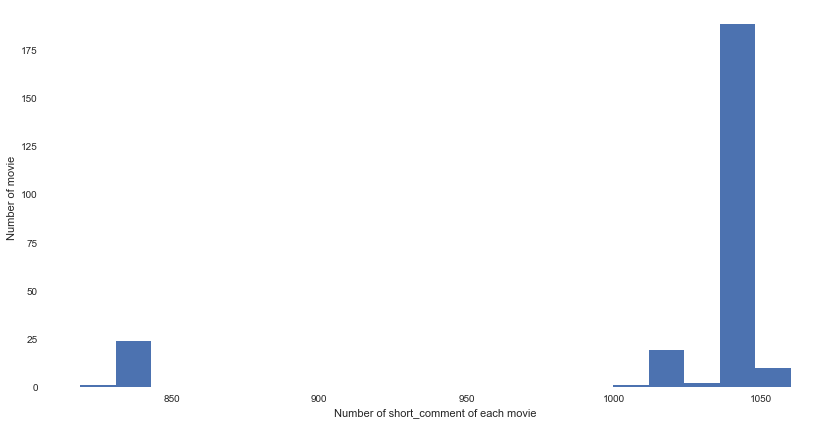

In [16]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

data_com.movie_id.value_counts().hist(bins=20)
plt.ylabel('Number of movie')
plt.xlabel('Number of short_comment of each movie')

In [17]:
# 1. 就《肖申克的救赎》这个电影而言

In [28]:
data_com_X = data_com[data_com.movie_id == 1292052]
print('爬取《肖申克的救赎》的短评数：', data_com_X.shape[0])

爬取《肖申克的救赎》的短评数： 1040
爬取《肖申克的救赎》的短评数： 1040


In [29]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

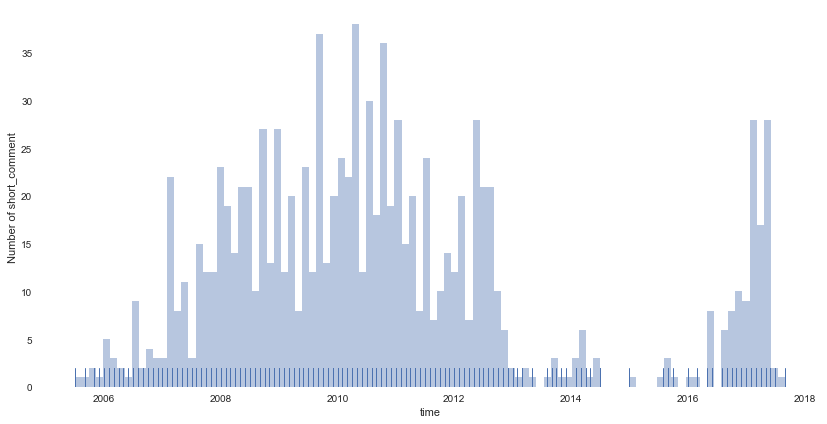

In [38]:
sns.distplot(data_com_X.time.apply(lambda x: int(x.year)+float(x.month/12.0)), bins=100, kde=False, rug=True)
plt.xlabel('time')
plt.ylabel('Number of short_comment')

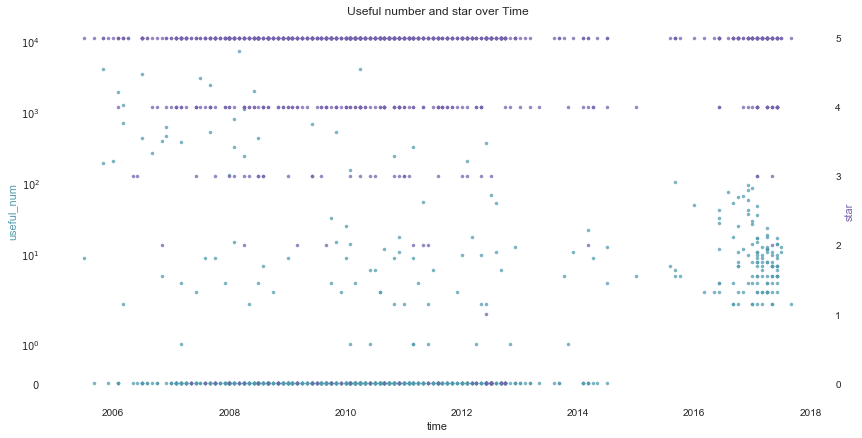

In [39]:
plot2y(x_data = data_com_X.time.apply(lambda x: int(x.year)+float(x.month/12.0))
           , x_label = 'time'
           , type1 = 'scatter'
           , y1_data = data_com_X['useful_num']
           , y1_color = '#539caf'
           , y1_label = 'useful_num'
           , type2 = 'scatter'
           , y2_data = data_com_X['star']
           , y2_color = '#7663b0'
           , y2_label = 'star'
           , title = 'Useful number and star over Time')

In [ ]:
# 短评词云

In [40]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
from wordcloud import WordCloud # 词云包

In [41]:
content_X = data_com_X.content.dropna().values.tolist()
# 导入、分词
segment=[]
for line in content_X: 
    try:
        segs = jieba.lcut(line) # jiaba.lcut()   
        for seg in segs:
            if len(seg)>1 and seg!='\r\n':
                segment.append(seg)
    except:
        print(line)
        continue

In [42]:
# 去停用词
words_df = pd.DataFrame({'segment':segment})
stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
#stopwords.head()
words_df=words_df[~words_df.segment.isin(stopwords.stopword)]

In [43]:
# 统计词频
words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数":np.size})
words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False)
#words_stat.head()

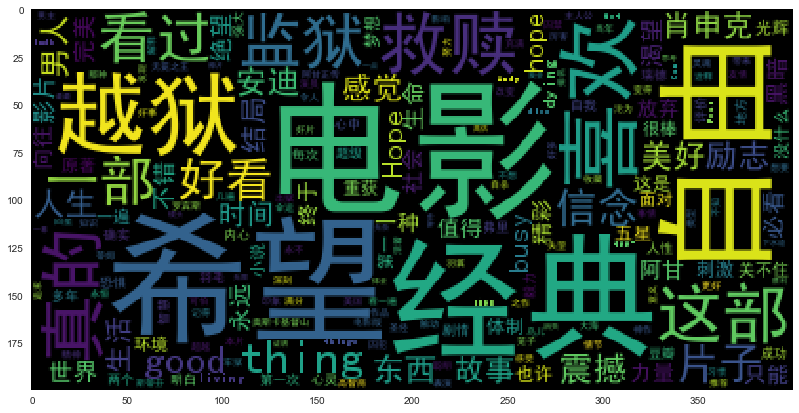

In [44]:
# 词云
wordcloud = WordCloud(font_path="../simhei.ttf"
                      ,background_color="black"
                      ,max_font_size=80)
word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

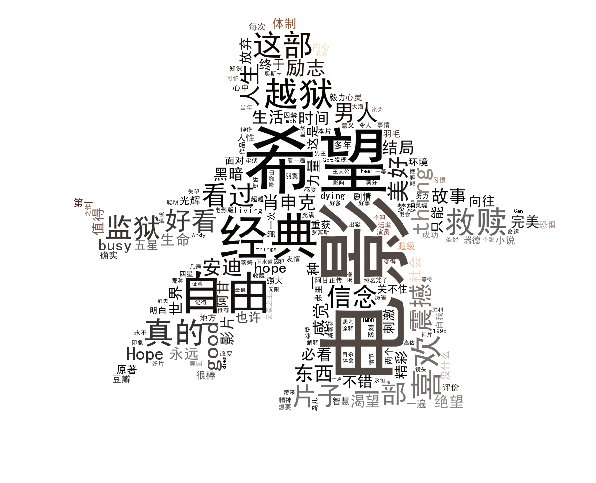

In [45]:
# 加入自定义图
from scipy.misc import imread
matplotlib.rcParams['figure.figsize']=(10.0,10.0)
from wordcloud import WordCloud,ImageColorGenerator
bimg=imread('cover.jpg')
wordcloud=WordCloud(background_color="white",mask=bimg,font_path='../simhei.ttf',max_font_size=200)
word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence)
bimgColors=ImageColorGenerator(bimg)
plt.axis("off")
plt.imshow(wordcloud.recolor(color_func=bimgColors))

In [ ]:
# 用朴素贝叶斯完成中文文本分类器

In [52]:
data_com_X.label.value_counts()

NameError: name 'data_com_X' is not defined

In [47]:
# 词云
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd

def preprocess_text(content_lines,sentences,category):
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

In [31]:
data_com_X_1 = data_com_X[data_com_X.label == 1]
data_com_X_0 = data_com_X[data_com_X.label == 0]

In [53]:
# 下采样
sentences=[]
preprocess_text(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
while n <20:
    preprocess_text(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1

In [54]:
import random
random.shuffle(sentences)
for sentence in sentences[:2]:
    print(sentence[0], sentence[1])

的确 地方 落下 泪来 nlike
自作聪明 nlike


In [64]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score
#from sklearn.model_selection import train_test_split
x,y=zip(*sentences)
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
    analyzer='word', # tokenise by character ngrams 
    ngram_range=(1,4), # use ngrams of size 1 and 2 
    max_features=20000, # keep the most common 1000 ngrams
)
vec.fit(x)

def stratifiedkfold_cv(x,y,clf_class,shuffle=True,n_folds=5,**kwargs):
    stratifiedk_fold = StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y[:]
    for train_index, test_index in stratifiedk_fold:
        X_train, X_test = x[train_index], x[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

NB = MultinomialNB
print(precision_score(y
                      ,stratifiedkfold_cv(vec.transform(x)
                                          ,np.array(y),NB)
                      , average='macro'))

0.872269356854


In [66]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

class TextClassifier():
    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier
        self.vectorizer = CountVectorizer(analyzer='word'
                                          ,ngram_range=(1,4)
                                          ,max_features=20000)
    def features(self, X):
        return self.vectorizer.transform(X)
    
    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)
        
    def predict(self, x):
        return self.classifier.predict(self.features([x]))
    
    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

In [67]:
text_classifier=TextClassifier()
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1234)
text_classifier.fit(x_train,y_train)
print(text_classifier.predict('一点 不觉得震撼'))
print(text_classifier.predict('好看'))
print(text_classifier.score(x_test,y_test))

['nlike']
['nlike']
0.913223140496


In [ ]:
# 用SVC完成中文文本分类器

In [68]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC

class TextClassifier():
    def __init__(self, classifier=SVC(kernel='linear')):
        self.classifier = classifier
        self.vectorizer = TfidfVectorizer(analyzer='word'
                                          ,ngram_range=(1,4)
                                          ,max_features=20000)

    def features(self, X):
        return self.vectorizer.transform(X)
    
    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)
    
    def predict(self, x):
        return self.classifier.predict(self.features([x]))
    
    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

In [69]:
text_classifier=TextClassifier()
text_classifier.fit(x_train,y_train)
print(text_classifier.predict('一点 不觉得震撼'))
print(text_classifier.predict('好看'))
print(text_classifier.score(x_test,y_test))

['like']
['like']
0.971074380165


In [ ]:
# 用Facebook FastText有监督完成中文文本分类

In [70]:
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append("__label__"+str(category)+" , "+" ".join(segs))
        except:
            print(line)
            continue
            
# 生成训练数据            
sentences=[]
preprocess_text(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
while n <20:
    preprocess_text(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1
random.shuffle(sentences)

print("writing data to fasttext supervised learning format...")
out = open('train_data_supervised_fasttext.txt','w' )#,encoding='utf-8') 
for sentence in sentences:
    out.write(sentence+"\n") 
print("done!")

writing data to fasttext supervised learning format...
done!


In [71]:
# 调用fastTest模型
import fasttext
# 有监督
classifier=fasttext.supervised('train_data_supervised_fasttext.txt'
                               , 'classifier.model' #        
                               , label_prefix='__label__')
# 对模型进行评估
result = classifier.test('train_data_supervised_fasttext.txt')
print('P@1:',result.precision)
print('R@1:',result.recall)
print('Number of examples:',result.nexamples)

P@1: 0.9377753303964758
R@1: 0.9377753303964758
Number of examples: 1816


In [72]:
# 测试一下实际效果
texts = '真心 不好看'
labels=classifier.predict(texts)
print(labels[0][0])
labels=classifier.predict_proba(texts,k=2)
print(labels[0])

like
[('like', 0.820312), ('nlike', 0.177734)]


In [ ]:
# 用Facebook FastText无监督学习

In [73]:
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text_unsupervised(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append(" ".join(segs))
        except:
            print(line)
            continue

In [74]:
sentences=[]
preprocess_text_unsupervised(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
while n <20:
    preprocess_text_unsupervised(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1
random.shuffle(sentences)

print("writing data to fasttext unsupervised learning format...")
out=open('train_data_unsupervised_fasttext.txt','w') 
for sentence in sentences:
    out.write(sentence+"\n") 
print("done!")

writing data to fasttext unsupervised learning format...
done!


In [75]:
import fasttext
# Skipgram model
model=fasttext.skipgram('train_data_unsupervised_fasttext.txt','model') 
print(model.words) # list of words in dictionary
# CBOW model
#model=fasttext.cbow('train_data_unsupervised_fasttext.txt','model') 
#print(model.words) # list of words in dictionary

{'地方', '恐惧', '影视', '向往', '落下', '評分', '永不', '智慧', '總算', 'run', '好看', '激动', '豆瓣', '生活', '好多', '面对', '挖出来', '精妙', '心愿', '不差', '追求', '港译', '深刻', '活着', '时间', '信仰', '狗血', '历历在目', 'end', '橡树', '重获', '结局', '弗里', '惊叹', '社会', '那种', '启发', 'dream', '成功', '奥斯卡', 'hope', '故事', 'thought', '瑞德', '心灵', '触动', 'jail', '羽毛', '囚禁', '努力', '好评', '作品', '之作', '看过', '境界', '不错', '超越', '时个', '鸟儿', '该是', '感人', '穿越', '</s>', '光辉', '这部', '要命', 'Can', '变奏', '欣赏', '内心', '体制', '泪来', '1999', '环境', '阶梯教室', '赞誉', '不想', 'busy', '明白', 'escape', '决绝', '几遍', 'Nice', '冲动', '剧情', '传闻中', 'Hope', '诠释', 'bbm', '黑暗', '喜欢', '这是', '電影', '类型', '真的', '只能', '主题', '约会', 'nice', 'At', '好片', 'dying', '呼唤', '基督山', '演员', '毅力', '感受', '当年', '神作', '一部', '大众', '关不住', '一遍', '硕大', '梦想', '摩根', '过度', '第一', '上班族', '东西', '永远', '勇敢', '放弃', '美好', 'movie', '解救', '国产片', '厉害', '好奇', 'plan', '友情', '没看', '挺难', '很棒', '脱离', '妻子', '意义', '四星', '确实', '原著', '人性', '片子', '电影版', '心中', '习惯', '鉴赏', '渴望', '假释', '那個', '值得', '最高分', '红歌', '知识', '更好', '力量', '精神', 'good', 'm

In [ ]:
# 用CNN做中文文本分类

In [134]:
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue
            
sentences=[]
preprocess_text(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
while n <20:
    preprocess_text(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1
random.shuffle(sentences)     

from sklearn.model_selection import train_test_split
x,y=zip(*sentences)
train_data,test_data,train_target,test_target=train_test_split(x, y, random_state=1234)

In [135]:
"""
基于卷积神经网络的中文文本分类
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

learn = tf.contrib.learn
FLAGS = None
# 文档最长长度
MAX_DOCUMENT_LENGTH = 100
# 最小词频数
MIN_WORD_FREQUENCE = 2
# 词嵌入的维度
EMBEDDING_SIZE = 20
# filter个数
N_FILTERS = 10 # 10个神经元
# 感知野大小
WINDOW_SIZE = 20
#filter的形状
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS] 
# 池化
POOLING_WINDOW = 4
POOLING_STRIDE = 2
n_words = 0

def cnn_model(features, target):
    """
    2层的卷积神经网络，用于短文本分类
    """
    # 先把词转成词嵌入
    # 我们得到一个形状为[n_words, EMBEDDING_SIZE]的词表映射矩阵
    # 接着我们可以把一批文本映射成[batch_size, sequence_length,EMBEDDING_SIZE]的矩阵形式
    target = tf.one_hot(target, 15, 1, 0) #对词编码
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    word_vectors = tf.expand_dims(word_vectors, 3)
    with tf.variable_scope('CNN_Layer1'):
        # 添加卷积层做滤波
        conv1 = tf.contrib.layers.convolution2d(word_vectors
                                                ,N_FILTERS
                                                ,FILTER_SHAPE1
                                                ,padding='VALID')
        # 添加RELU非线性
        conv1 = tf.nn.relu(conv1) 
        # 最大池化
        pool1 = tf.nn.max_pool(conv1
                               ,ksize=[1, POOLING_WINDOW, 1, 1]
                               ,strides=[1, POOLING_STRIDE, 1, 1]
                               ,padding='SAME')
        # 对矩阵进行转置，以满足形状
        pool1 = tf.transpose(pool1, [0, 1, 3, 2])
    with tf.variable_scope('CNN_Layer2'):
        # 第2卷积层
        conv2 = tf.contrib.layers.convolution2d(pool1
                                                ,N_FILTERS
                                                ,FILTER_SHAPE2
                                                ,padding='VALID') 
        # 抽取特征
        pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])
        
    # 全连接层
    logits = tf.contrib.layers.fully_connected(pool2, 15, activation_fn=None)
    loss = tf.losses.softmax_cross_entropy(target, logits) 
    # 优化器
    train_op = tf.contrib.layers.optimize_loss(loss
                                               ,tf.contrib.framework.get_global_step()
                                               ,optimizer='Adam'
                                               ,learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)

In [136]:
global n_words
# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE) 
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data)))
n_words=len(vocab_processor.vocabulary_) 
print('Total words:%d'%n_words)

cate_dic={'like':1,'nlike':0}
y_train = pd.Series(train_target).apply(lambda x:cate_dic[x] , train_target)
y_test = pd.Series(test_target).apply(lambda x:cate_dic[x] , test_target)

Total words:404


In [137]:
# 构建模型
classifier=learn.SKCompat(learn.Estimator(model_fn=cnn_model))

# 训练和预测
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class'] 
score=metrics.accuracy_score(y_test,y_predicted) 
print('Accuracy:{0:f}'.format(score))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_save_summary_steps': 100, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1570ddc50>, '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmpqmjhhkun', '_environment': 'local', '_num_worker_replicas': 0, '_num_ps_replicas': 0, '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_task_type': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmpqmjhhkun/model.ckpt.
INFO:tensorflow:step = 1, loss = 2.70766
INFO:tensorflow:global_step/sec: 10.5174
INFO:tensorflow:step = 101, loss = 0.690472 (9.510 sec)
INFO:tensor

KeyboardInterrupt: 

In [ ]:
# 用RNN做中文文本分类

In [20]:
"""
使用RNN完成文本分类
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.layers.python.layers import encoders

learn = tf.contrib.learn

FALGS = None

In [21]:
MAX_DOCUMENT_LENGTH=15
MIN_WORD_FREQUENCE=1
EMBEDDING_SIZE=50
global n_words

# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE)
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data))) 
n_words = len(vocab_processor.vocabulary_)
print('Total words: %d' % n_words)

def bag_of_words_model(features, target): 
    """
    先转成词袋模型
    """
    target = tf.one_hot(target, 15, 1, 0)
    features = encoders.bow_encoder(features
                                    ,vocab_size=n_words
                                    ,embed_dim=EMBEDDING_SIZE)
    logits = tf.contrib.layers.fully_connected(features, 15
                                               ,activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    train_op = tf.contrib.layers.optimize_loss(loss
                                               ,tf.contrib.framework.get_global_step()
                                               ,optimizer='Adam'
                                               ,learning_rate=0.01)
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)

model_fn = bag_of_words_model
classifier = learn.SKCompat(learn.Estimator(model_fn=model_fn))

# Train and predict
classifier.fit(x_train, y_train, steps=1000)
y_predicted = classifier.predict(x_test)['class']
score = metrics.accuracy_score(y_test, y_predicted)
print('Accuracy: {0:f}'.format(score))

NameError: name 'train_data' is not defined

NameError: name 'train_data' is not defined

In [ ]:
# 用GRU来完成中文文本分类

In [34]:
def rnn_model(features,target): 
    """
    用RNN模型（这里用的是GRU）完成文本分类
    """
    # Convert indexes of words into embeddings.
    # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
    # maps word indexes of the sequence into [batch_size,sequence_length,
    # EMBEDDING_SIZE].
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    # Split into list of embedding per word, while removing doc length dim。
    # word_list results to be a list of tensors [batch_size,EMBEDDING_SIZE].
    word_list = tf.unstack(word_vectors, axis=1)
    
    # Create a Gated Recurrent Unit cell with hidden size of EMBEDDING_SIZE.
    cell = tf.contrib.rnn.GRUCell(EMBEDDING_SIZE)
    
    # Create an unrolled Recurrent Neural Networks to length of
    # MAX_DOCUMENT_LENGTH and passes word_list as inputs for each unit.
    _, encoding = tf.contrib.rnn.static_rnn(cell, word_list, dtype=tf.float32)
    
    # Given encoding of RNN, take encoding of last step (e.g hidden size of the
    # neural network of last step) and pass it as features for logistic
    # regression over output classes.
    target = tf.one_hot(target, 15, 1, 0)
    logits = tf.contrib.layers.fully_connected(encoding, 15, activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    
    # Create a training op.
    train_op = tf.contrib.layers.optimize_loss(
            loss,
            tf.contrib.framework.get_global_step(),
            optimizer='Adam',
            learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)


model_fn = rnn_model 
classifier=learn.SKCompat(learn.Estimator(model_fn=model_fn))

#Train and predict
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class']
score=metrics.accuracy_score(y_test,y_predicted)
print('Accuracy:{0:f}'.format(score))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_save_summary_steps': 100, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13d895f98>, '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmp8ty32mwe', '_environment': 'local', '_num_worker_replicas': 0, '_num_ps_replicas': 0, '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_task_type': None}
INFO:tensorflow:Using config: {'_evaluation_master': '', '_save_summary_steps': 100, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13d895f98>, '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_

Accuracy:0.933884
Accuracy:0.933884


In [35]:
def pred(commment):
    sentences=[]
    preprocess_text([commment] ,sentences, 'unknown')
    x,y=zip(*sentences)
    x_tt = np.array(list(vocab_processor.transform([x[0]])))
    
    if classifier.predict(x_tt)['class'][0]:
        print('like')
    else:
        print('nlike')
pred('好精彩的电影！')
pred('烂片啊！')

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Restoring parameters from /var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmp8ty32mwe/model.ckpt-1000
INFO:tensorflow:Restoring parameters from /var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmp8ty32mwe/model.ckpt-1000
like
like
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.softmax_cross_

In [ ]:
# 2. 全部影片的短评数据分析

In [36]:
data_com_0

,comment_id,content,movie_id,people,star,time,useful_num,label
9,34253734,真的不喜欢，不好看，没感觉,1292052,九尾黑猫,2,2008-03-19 00:32:02,1107,0
18,6040147,有那么好吗？？？？？,1292052,我不绝望,2,2006-10-05 22:11:30,391,0
42,39174583,好看在哪里了？竟然这么多人喜欢，奇怪。,2365260,女魔头,2,2008-05-02 15:53:09,482,0
46,39349806,俊男靓女也无法阻止它迈向闷片的步伐。,2365260,飞天PP猪,2,2008-05-03 21:31:59,252,0
55,54777342,"没有什么惊天动地的,翻天覆地的,纯纯的,轻轻的,却让眼睛忍不住一下就酸了。TONG跟MEW的...",2365260,尼桑，都是尼桑的错,0,2008-08-17 09:12:54,105,0
59,38237626,——太多的爱，即使会让我们犯了错；但比起未曾为爱做过任何事好太多了，不是吗？\r\n——如果...,2365260,逍遥兽,0,2008-04-24 22:37:45,63,0
60,9350578,太扯了，两个男人，在一起生活了几百年，没有其他伴侣，竟然什么都没发生？,1299327,harumi,0,2007-01-18 18:20:00,2140,0
63,513057700,小时候看过一部电影，主角是个基佬，基佬找了个男人，但那个男人是个罗莉控。他和萝莉暗算了基佬，...,1299327,陆秋槎,0,2012-03-26 23:26:29,786,0
69,47300430,暴殄天物啊！攥着三个超级大帅哥就拍成了这样？看不懂~~,1299327,战国客,2,2008-07-01 13:59:14,260,0
75,2099700,没看完就看不下去了,1299327,nadja,2,2006-03-25 18:35:26,97,0


,comment_id,content,movie_id,people,star,time,useful_num,label
9,34253734,真的不喜欢，不好看，没感觉,1292052,九尾黑猫,2,2008-03-19 00:32:02,1107,0
18,6040147,有那么好吗？？？？？,1292052,我不绝望,2,2006-10-05 22:11:30,391,0
42,39174583,好看在哪里了？竟然这么多人喜欢，奇怪。,2365260,女魔头,2,2008-05-02 15:53:09,482,0
46,39349806,俊男靓女也无法阻止它迈向闷片的步伐。,2365260,飞天PP猪,2,2008-05-03 21:31:59,252,0
55,54777342,"没有什么惊天动地的,翻天覆地的,纯纯的,轻轻的,却让眼睛忍不住一下就酸了。TONG跟MEW的...",2365260,尼桑，都是尼桑的错,0,2008-08-17 09:12:54,105,0
59,38237626,——太多的爱，即使会让我们犯了错；但比起未曾为爱做过任何事好太多了，不是吗？\r\n——如果...,2365260,逍遥兽,0,2008-04-24 22:37:45,63,0
60,9350578,太扯了，两个男人，在一起生活了几百年，没有其他伴侣，竟然什么都没发生？,1299327,harumi,0,2007-01-18 18:20:00,2140,0
63,513057700,小时候看过一部电影，主角是个基佬，基佬找了个男人，但那个男人是个罗莉控。他和萝莉暗算了基佬，...,1299327,陆秋槎,0,2012-03-26 23:26:29,786,0
69,47300430,暴殄天物啊！攥着三个超级大帅哥就拍成了这样？看不懂~~,1299327,战国客,2,2008-07-01 13:59:14,260,0
75,2099700,没看完就看不下去了,1299327,nadja,2,2006-03-25 18:35:26,97,0


In [ ]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
sns.distplot(data_com.time.apply(lambda x: int(x.year)+float(x.month/12.0)), bins=100, kde=False, rug=True)
plt.xlabel('time')
plt.ylabel('Number of short_comment')

KeyboardInterrupt: 

In [1]:
plot2y(x_data = data_com.time.apply(lambda x: int(x.year)+float(x.month/12.0))
           , x_label = 'time'
           , type1 = 'scatter'
           , y1_data = data_com_X['useful_num']
           , y1_color = '#539caf'
           , y1_label = 'useful_num'
           , type2 = 'scatter'
           , y2_data = data_com_X['star']
           , y2_color = '#7663b0'
           , y2_label = 'star'
           , title = 'Useful number and star over Time')

NameError: name 'plot2y' is not defined

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(10.0,5.0)
from wordcloud import WordCloud # 词云包

content_X = data_com_X.content.dropna().values.tolist()
# 导入、分词
segment=[]
for line in content_X: 
    try:
        segs = jieba.lcut(line) # jiaba.lcut()   
        for seg in segs:
            if len(seg)>1 and seg!='\r\n':
                segment.append(seg)
    except:
        print(line)
        continue
        
# 去停用词
words_df = pd.DataFrame({'segment':segment})
stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
#stopwords.head()
words_df=words_df[~words_df.segment.isin(stopwords.stopword)]

# 统计词频
words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数":np.size})
words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False)
#words_stat.head()

# 词云
wordcloud = WordCloud(font_path="../simhei.ttf"
                      ,background_color="white"
                      ,max_font_size=80)
word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

In [ ]:
# Deeplearning

In [12]:
data_com.label.value_counts()

1    237131
0     12381
Name: label, dtype: int64

1    237131
0     12381
Name: label, dtype: int64

In [13]:
data_com_1 = data_com[data_com.label == 1]
data_com_0 = data_com[data_com.label == 0]

In [14]:
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

In [16]:
sentences=[]
preprocess_text(data_com_1.content.dropna().values.tolist() ,sentences ,'like')
preprocess_text(data_com_0.content.dropna().values.tolist() ,sentences ,'nlike')

In [ ]:
n=0
while n <20:
    preprocess_text(data_com_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1
    print('Now n=',n)
random.shuffle(sentences)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/jieba.cache
Loading model cost 1.479 seconds.
Prefix dict has been built succesfully.


Ar u free?Ar u really free?


In [ ]:
from sklearn.model_selection import train_test_split
x,y=zip(*sentences)
train_data,test_data,train_target,test_target=train_test_split(x, y, random_state=1234)

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.layers.python.layers import encoders

learn = tf.contrib.learn

FALGS = None
MAX_DOCUMENT_LENGTH=15
MIN_WORD_FREQUENCE=1
EMBEDDING_SIZE=50
global n_words

global n_words
# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE) 
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data)))
n_words=len(vocab_processor.vocabulary_) 
print('Total words:%d'%n_words)

cate_dic={'like':1,'nlike':0}
y_train = pd.Series(train_target).apply(lambda x:cate_dic[x] , train_target)
y_test = pd.Series(test_target).apply(lambda x:cate_dic[x] , test_target)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
def rnn_model(features,target): 
    """
    用RNN模型（这里用的是GRU）完成文本分类
    """
    # Convert indexes of words into embeddings.
    # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
    # maps word indexes of the sequence into [batch_size,sequence_length,
    # EMBEDDING_SIZE].
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    # Split into list of embedding per word, while removing doc length dim。
    # word_list results to be a list of tensors [batch_size,EMBEDDING_SIZE].
    word_list = tf.unstack(word_vectors, axis=1)
    
    # Create a Gated Recurrent Unit cell with hidden size of EMBEDDING_SIZE.
    cell = tf.contrib.rnn.GRUCell(EMBEDDING_SIZE)
    
    # Create an unrolled Recurrent Neural Networks to length of
    # MAX_DOCUMENT_LENGTH and passes word_list as inputs for each unit.
    _, encoding = tf.contrib.rnn.static_rnn(cell, word_list, dtype=tf.float32)
    
    # Given encoding of RNN, take encoding of last step (e.g hidden size of the
    # neural network of last step) and pass it as features for logistic
    # regression over output classes.
    target = tf.one_hot(target, 15, 1, 0)
    logits = tf.contrib.layers.fully_connected(encoding, 15, activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    
    # Create a training op.
    train_op = tf.contrib.layers.optimize_loss(
            loss,
            tf.contrib.framework.get_global_step(),
            optimizer='Adam',
            learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)


model_fn = rnn_model 
classifier=learn.SKCompat(learn.Estimator(model_fn=model_fn))

#Train and predict
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class']
score=metrics.accuracy_score(y_test,y_predicted)
print('Accuracy:{0:f}'.format(score))

In [19]:
def pred(commment):
    sentences=[]
    preprocess_text([commment] ,sentences, 'unknown')
    x,y=zip(*sentences)
    x_tt = np.array(list(vocab_processor.transform([x[0]])))
    
    if classifier.predict(x_tt)['class'][0]:
        print('like')
    else:
        print('nlike')
pred('好精彩的电影！')

NameError: name 'vocab_processor' is not defined

NameError: name 'vocab_processor' is not defined

In [ ]:
pred('烂片啊！')

In [93]:
len(Xpeople_url)

1040

In [91]:
Xpeople_url = data_com[data_com.movie_id == 1292052].people_url.values.tolist()
np.savetxt('../douban_movie/bin/X_people_url.out', Xpeople_url, fmt='%s')

In [1096]:
#people_url = data_com.people_url.unique().tolist()
#np.savetxt('./douban_movie/bin/people_url.out', people_url, fmt='%s')
!ls ./douban_movie/data/movie_people.json
#urllist = np.loadtxt('./douban_movie/bin/people_url.out', dtype='|S').tolist()

ls: ./douban_movie/data/movie_people.json: No such file or directory


In [1098]:
!ls ../douban_movie/data

movie_comment100.json  movie_comment225.json  movie_people15000.json
movie_comment120.json  movie_comment250.json  movie_people20000.json
movie_comment140.json  movie_comment40.json   movie_people25000.json
movie_comment160.json  movie_comment60.json   movie_people30000.json
movie_comment180.json  movie_comment80.json   movie_people35000.json
movie_comment20.json   movie_item.json        movie_people40000.json
movie_comment200.json  movie_people10000.json movie_people5000.json


In [160]:
import pandas as pd
import numpy as np
import json
import re
# 短评人数据
movie_people_file = ['../douban_movie/data/movie_people%s.json' %j for j in [ i for i in range(5000,45000,5000)] ]
peo = []
for f in movie_people_file:
    lines = open(f, 'rb').readlines()
    peo.extend([json.loads(elem.decode("utf-8")) for elem in lines])
data_peo = pd.DataFrame(peo)
data_peo.shape
# 去掉空值
data_peo = data_peo[~data_peo.friend.apply(lambda x: not (x[:])) \
         & ~data_peo.be_attention.apply(lambda x: not (x[:])) \
        & ~data_peo.location.apply(lambda x: not (x[:])) \
        &  ~data_peo.introduction.apply(lambda x: not (x[:])) ]

data_peo['friend'] = data_peo.friend.apply(lambda x: int(str(x)[4:-2]) )
data_peo['be_attention'] = data_peo.be_attention.apply(lambda x: int(re.findall(r"被(\d+)人", str(x))[0]) )
data_peo['location'] = data_peo.location.apply(lambda x: x[0])
data_peo.head()
data_peo.shape

(26321, 4)

In [161]:
data_peo.head()

,be_attention,friend,introduction,location
0,1350,376,"[假如可以带粉笔进入迷宫，以纯蓝\r, 标记每一处通往灾祸的岔口：“我到过这儿\r, 必将永...",广东广州
2,774,364,"[ , 吃好吃的东西，过短命的人生, ]",福建漳州
3,99,92,[一个出生、成长都在江南水乡的70后。],江苏宜兴
4,1793,664,"[爱与和平 , 政治立场坐标, 0.8, 文化立场坐标, -0.2, 经济立场坐标...",北京
6,8457,1406,"[个人主页：兔鼠馆, -----------------------, 互相点蜡吧，终须一别...",北京


In [162]:
def locaP(x):
    prov_dic = {'黑龙江':'黑龙江省', '内蒙': '内蒙古自治区', '新疆': '新疆维吾尔自治区'
            ,'吉林': '吉林省', '辽宁': '辽宁省', '甘肃': '甘肃省', '河北': '河北省'
            ,'北京': '北京市', '山西': '山西省', '天津': '天津市', '陕西': '陕西省'
            ,'宁夏': '宁夏回族自治区', '青海': '青海省', '山东': '山东省', '西藏':  '西藏自治区'
            ,'河南': '河南省', '江苏': '江苏省', '安徽': '安徽省', '四川': '四川省'
            ,'湖北': '湖北省', '重庆': '重庆市', '上海': '上海市', '浙江': '浙江省'
            ,'湖南': '湖南省', '江西': '江西省', '云南': '云南省', '贵州': '贵州省'
            ,'福建': '福建省', '广西': '广西壮族自治区', '台湾': '台湾省', '广东':  '广东省'
            ,'香港': '香港特别行政区','澳门': '香港特别行政区', '海南': '海南省'
               , '苏州':'江苏省','威海':'山东省','嘉兴':'浙江省','锡林浩特':'内蒙古自治区'
               , '温州':'浙江省','肇庆': '广东省','红河':'云南省','延边':'吉林省'
               , '衢州':'浙江省','伊宁': '新疆维吾尔自治区','遵义':'贵州省','绍兴':'浙江省'
               , '库尔勒':'新疆维吾尔自治区','杭州':'浙江省','通化':'吉林省'}

    for d in prov_dic:
        if d in x:  return prov_dic[d]

def locaC(x):        
    country_dict = {'China':'China','United States':'United States','Hong Kong':'Hong Kong','Taiwan':'Taiwan, Province of China'
                 ,'Japan':'Japan','Korea':'Korea, Republic of','United Kingdom':'United Kingdom','France':'France','Germany':'Germany'
                 ,'Italy':'Italy','Spain':'Spain','India':'India','Thailand':'Thailand','Russia':'Russian Federation'
                 ,'Iran':'Iran','Canada':'Canada','Australia':'Australia','Ireland':'Ireland','Sweden':'Sweden'
                 ,'Brazil':'Brazil','Denmark':'Denmark','Singapore':'Singapore','Cuba':'Cuba','Iceland':'Iceland'
                    ,'Netherlands':'Netherlands', 'Switzerland':'Switzerland','Bahamas':'Bahamas','Sierra Leone':'Sierra Leone'
                    ,'Finland':'Finland','Czech Republic':'Czech Republic','Egypt':'Egypt','Turkey':'Turkey','Argentina':'Argentina'
                   ,'Bolivia':'Bolivia','Norway':'Norway','Indonesia':'Indonesia','Chile':'Chile','Morocco':'Morocco','Andorra':'Andorra'
                   ,'Senegal':'Senegal','Somalia':'Somalia','Haiti':'Haiti','Portugal':'Portugal','Togo':'Togo','New Zealand':'New Zealand'
                   ,'Hungary':'Hungary','Bulgaria':'Bulgaria','Afghanistan':'Afghanistan','Niue':'Niue','Austria':'Austria'
                   ,'Peru':'Peru','Greece':'Greece','Luxembourg':'Luxembourg','Greenland':'Greenland','Fiji':'Fiji','Jordan':'Jordan'
                   ,'Reunion':'Reunion','Bhutan':'Bhutan','Barbados':'Barbados','Malaysia':'Malaysia','Ghana':'Ghana'
                   ,'Poland':'Poland','Guinea':'Guinea','Belgium':'Belgium','Zimbabwe':'Zimbabwe','Aruba':'Aruba','Anguilla':'Anguilla'
                   ,'Nepal':'Nepal','Latvia':'Latvia','Philippines':'Philippines','United Arab Emirates':'United Arab Emirates'
                   ,'Saudi Arabia':'Saudi Arabia','South Africa':'South Africa','Mexico':'Mexico','Syrian':'Syrian Arab Republic'
                   ,'Sudan':'Sudan','Iraq':'Iraq','Slovenia':'Slovenia','Tunisia':'Tunisia','Nicaragua':'Nicaragua','Kazakhstan':'Kazakhstan'
                   ,'Bahrain':'Bahrain','Vietnam':'Viet Nam','Tuvalu':'Tuvula','Vatican City':'Vatican City State (Holy See)'
                   ,'Wallis et Futuna':'Wallis and Futuna Islands','Tanzania':'Tanzania, United Republic of'
                   ,'Libya':'Liby An Arab Jamahiriya','Western Sahara':'Western Sahara','Syria':'Syrian Arab Republic'
                   ,'Faroe Islands':'Faroe Islands','Sao Tome and Principe':'Sao Tome and Principe'
                   ,'Christmas Islands':'Christmas Islands','Costa Rica':'Costa Rica','Antarctica':'Antartica'
                   ,'Cook Islands':'Cook Islands','Kuwait':'Kuwait','Bermuda':'Bermuda','El Salvador':'El Salvador'
                   ,'Ethiopia':'Ethiopia','Mozambique':'Mozambique','Guyana':'Guyana','Mongolia':'Mongolia','Eritrea':'Eritrea'
                   ,'Monaco':'Monaco','Gibraltar':'Gibralter','Yemen':'Yemen','Micronesia':'Micronesia, (Federated States of)'
                   ,'Colombia':'Columbia','Guadeloupe':'Guadeloupe','Antigua':'Antigua & Barbuda','Caledonia':'New Caledonia'
                   ,'Cambodia':'Cambodia','Franch Guiana':'French Guiana','Vanuatu':'Vanuatu','Puerto Rico':'Puerto Rico'
                   ,'Belize':'Belize','Angola':'Angola','Dominica':'Dominica','Albania':'Albania','Azerbaijan':'Azerbaijan'
                   ,'Ukraine':'Ukraine','Grenada':'Grenada','Panama':'Panama','Israel':'Israel','Guatemala':'Guatemala'
                   ,'Belarus':'Belarus','Cameroon':'Cameroon','Jamaica':'Jamaica','Warwickshire':'United Kingdom'
                   ,'Madagascar':'Madagascar','Mali':'Mali','Tokelau':'Tokelau','Benin':'Benin','Malta':'Malta'
                   ,'Gabon':'Gabon','Algeria':'Algeria','Kildare':'Ireland','Ecuador':'Ecuador','Pakistan':'Pakistan'
                   ,'Chad':'Chad','Paraguay':'Paraguay','Leicestershire':'Ireland','Estonia':'Estonia','Maldives':'Maldives'
                   ,'Liechtenstein':'Liechtenstein','Cyprus':'Cyprus','Zambia':'Zambia','Macedonia':'Macedonia, The Former Republic of Yugoslavia'
                   ,'Bouvet':'Bouvet Island','Uganda':'Uganda','Northern Marianas':'Northern Mariana Islands'
                   ,'Miquelon':'St. Pierre and Miquelon','Pitcairn':'Pitcairn','Slovakia':'Slovakia','Norfolk':'Norfolk Island'
                   ,'Lanka':'Sri Lanka','Congo':'Congo','Cocos':'Cocos (Keeling) Islands','Serbia':'Bulgaria','Croatia':'Croatia'
                   ,'Palestinian':'Israel','Armenia':'Armenia','Saint Barthélemy':'France','Sint Maarten':'France'
                   ,'Côte':"Cote D'ivoire (Ivory Coast)",'Jersey':'United Kingdom','Isle of Man':'United Kingdom'
                   ,'Aland Islands':'Finland','Kosovo':'Yugoslavia','Montenegro':'Yugoslavia'}
    for d in country_dict:
        if d in x:  return country_dict[d]    
        

In [163]:
data_peo['province'] = data_peo.location.apply(locaP)
data_peo.province.fillna('oversea', inplace = True)
data_peo['country'] = data_peo.location.apply(lambda x : x.split(sep = ',')[-1].strip()).apply(locaC)
data_peo.country.fillna('China', inplace = True)
data_peo.tail()

,be_attention,friend,introduction,location,province,country
34869,91,150,[还行吧],贵州贵阳,贵州省,China
34870,172,229,[口头上的反消费主义者],"London, United Kingdom",oversea,United Kingdom
34871,35966,225,"[一切热衷都是爱的耗散，一种甜美的耗散。, 出版的书：, 《一起来吃早午餐》, 《假如我有一...",北京,北京市,China
34872,683,136,"[sukida是我在08年夏天看的一部电影后起的, 电影的情节我都没有印象，唯一的印象就是s...",北京,北京市,China
34873,6,6,[I am the captain of my soul……],浙江杭州,浙江省,China


In [17]:
# 短评都是来自哪些国家呢？

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,country
0,China,22351
1,United States,1160
2,United Kingdom,354
3,Japan,302
4,Australia,271


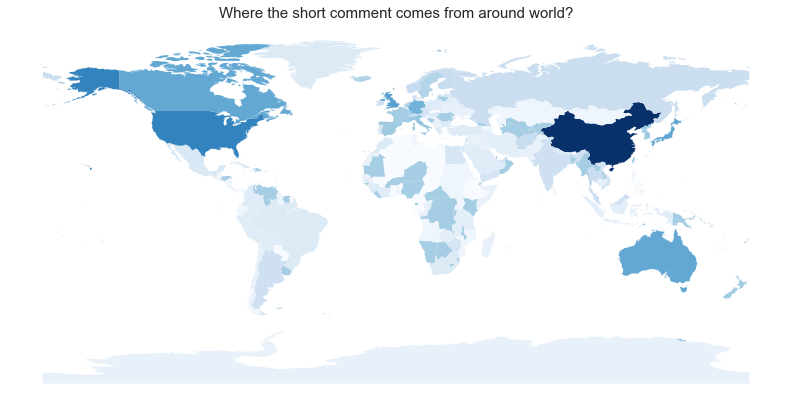

In [18]:
temp0 = data_peo.country.value_counts().reset_index()
df = pd.DataFrame({'NAME': temp0['index'].tolist()                    
                   ,'NUM': (np.log1p(temp0['country'])+10).tolist()}
                 )
geod_world(df, 'Where the short comment comes from around world? ', )
temp0.head()

In [ ]:
# 在中国范围内，哪些省份的短评人更活跃呢？

In [1]:
def geod_china(df, title, legend = False):
    """
    temp0 = temp.reset_index()
    df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
                   ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
    """
    import geopandas as gp
    from matplotlib import pyplot as plt
    %matplotlib inline
    import matplotlib
    import seaborn as sns
    matplotlib.rc('figure', figsize = (14, 7))
    matplotlib.rc('font', size = 14)
    matplotlib.rc('axes', grid = False)
    matplotlib.rc('axes', facecolor = 'white')

    china_geod = gp.GeoDataFrame.from_file('./china_shp/bou2_4p.shp',encoding = 'gb18030')
    data_geod = gp.GeoDataFrame(df)   # 转换格式
    da_merge = china_geod.merge(data_geod, on = 'NAME', how = 'left') # 合并
    sum(np.isnan(da_merge['NUM']))#
    da_merge['NUM'][np.isnan(da_merge['NUM'])] = 14.0#填充缺失数据
    da_merge.plot('NUM', k = 20, cmap = plt.cm.Blues,alpha= 1, legend = legend)
    plt.title(title, fontsize=15)#设置图形标题
    plt.gca().xaxis.set_major_locator(plt.NullLocator())#去掉x轴刻度
    plt.gca().yaxis.set_major_locator(plt.NullLocator())#去年y轴刻度

In [2]:
temp0 = data_peo.province.value_counts().reset_index()
df = pd.DataFrame({'NAME': temp0['index'].tolist()                    
                   ,'NUM': (np.log1p(temp0['province'])).tolist()}
                 )
geod_china(df, 'Where the short comment comes from in China? ', legend = False)
temp0.head(10)

NameError: name 'data_peo' is not defined

NameError: name 'data_peo' is not defined

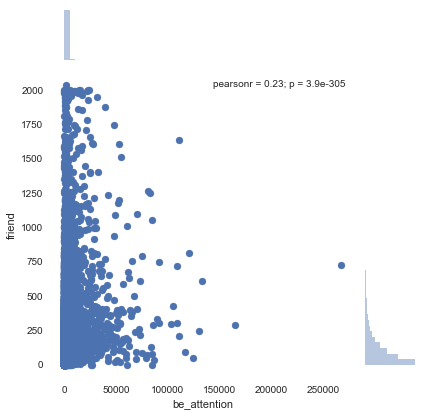

In [27]:
# 关于所有短评人的被关注数和好友数
sns.jointplot(x="be_attention", y="friend", data=data_peo)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,0
0,北京市,1572.960519
1,新疆维吾尔自治区,1399.703704
2,oversea,1380.422166
3,云南省,1304.207273
4,西藏自治区,1211.393939
5,上海市,989.342950
6,台湾省,876.506494
7,广东省,833.711997
8,广西壮族自治区,776.355263
9,四川省,729.574735


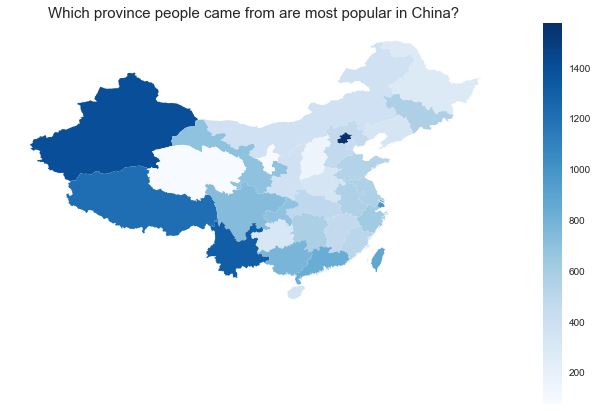

In [30]:
# 被关注数放在地域上来看
temp0 = (data_peo.groupby(by='province').sum().be_attention / data_peo.province.value_counts())\
        .sort_values(ascending=False).reset_index()

df = pd.DataFrame({'NAME': temp0['index'].tolist()                    
                   ,'NUM': temp0.ix[:,1].tolist()}
                 )
geod_china(df, 'Which province people came from are most popular in China? ', legend = True)
temp0.head(10)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,0
0,甘肃省,217.758621
1,西藏自治区,183.696970
2,台湾省,172.480519
3,北京市,172.128718
4,山西省,160.919540
5,上海市,152.031109
6,oversea,150.802519
7,云南省,149.523636
8,山东省,147.319398
9,香港特别行政区,145.855297


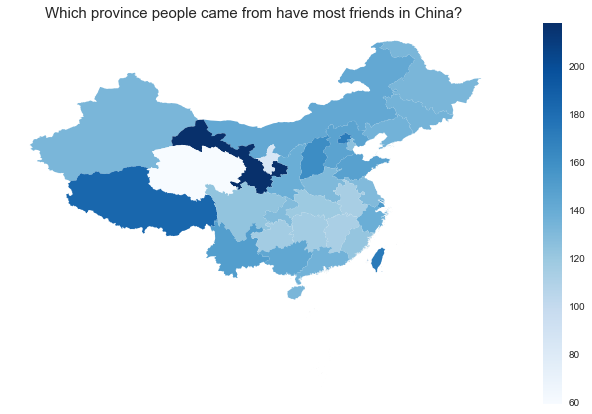

In [32]:
# 好友数放在地域上来看
temp0 = (data_peo.groupby(by='province').sum().friend / data_peo.province.value_counts())\
        .sort_values(ascending=False).reset_index()

df = pd.DataFrame({'NAME': temp0['index'].tolist()                    
                   ,'NUM': temp0.ix[:,1].tolist()}
                 )
geod_china(df, 'Which province people came from have most friends in China? ', legend = True)
temp0.head(10)

In [ ]:
# 5. 根据点评人个人简介构建中文文本分类模型

In [151]:
# label数据处理
def fixIntro(x):
    n = ''
    for i in x:
        n += i.strip()
        n +=' '
    return n
data_peo['introduction'] = data_peo.introduction.apply(fixIntro)
data_peo_b = data_peo[data_peo.province == '北京市']
data_peo_s = data_peo[data_peo.province == '上海市']
#data_peo_o = data_peo[data_peo.province == 'oversea']

In [139]:
# 切词
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

sentences=[]
preprocess_text(data_peo_b.introduction.dropna().values.tolist() ,sentences ,'北京')
preprocess_text(data_peo_s.introduction.dropna().values.tolist() ,sentences ,'上海')
#preprocess_text(data_peo_o.introduction.dropna().values.tolist() ,sentences ,'国外')
random.shuffle(sentences)            

In [140]:
# 切分训练集和测试集
from sklearn.model_selection import train_test_split
x,y=zip(*sentences)
train_data,test_data,train_target,test_target=train_test_split(x, y, random_state=1234)

In [152]:
"""
基于卷积神经网络的中文文本分类
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

learn = tf.contrib.learn
FLAGS = None
# 文档最长长度
MAX_DOCUMENT_LENGTH = 100
# 最小词频数
MIN_WORD_FREQUENCE = 2
# 词嵌入的维度
EMBEDDING_SIZE = 20
# filter个数
N_FILTERS = 10 # 10个神经元
# 感知野大小
WINDOW_SIZE = 20
#filter的形状
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS] 
# 池化
POOLING_WINDOW = 4
POOLING_STRIDE = 2
n_words = 0

def cnn_model(features, target):
    """
    2层的卷积神经网络，用于短文本分类
    """
    # 先把词转成词嵌入
    # 我们得到一个形状为[n_words, EMBEDDING_SIZE]的词表映射矩阵
    # 接着我们可以把一批文本映射成[batch_size, sequence_length,EMBEDDING_SIZE]的矩阵形式
    target = tf.one_hot(target, 15, 1, 0) #对词编码
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    word_vectors = tf.expand_dims(word_vectors, 3)
    
    with tf.variable_scope('CNN_Layer1'):
        # 添加卷积层做滤波
        conv1 = tf.contrib.layers.convolution2d(word_vectors
                                                ,N_FILTERS
                                                ,FILTER_SHAPE1
                                                ,padding='VALID')
        # 添加RELU非线性
        conv1 = tf.nn.relu(conv1) 
        # 最大池化
        pool1 = tf.nn.max_pool(conv1
                               ,ksize=[1, POOLING_WINDOW, 1, 1]
                               ,strides=[1, POOLING_STRIDE, 1, 1]
                               ,padding='SAME')
        # 对矩阵进行转置，以满足形状
        pool1 = tf.transpose(pool1, [0, 1, 3, 2])
    with tf.variable_scope('CNN_Layer2'):
        # 第2卷积层
        conv2 = tf.contrib.layers.convolution2d(pool1
                                                ,N_FILTERS
                                                ,FILTER_SHAPE2
                                                ,padding='VALID') 
        # 抽取特征
        pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])
        
    # 全连接层
    logits = tf.contrib.layers.fully_connected(pool2, 15, activation_fn=None)
    loss = tf.losses.softmax_cross_entropy(target, logits) 
    # 优化器
    train_op = tf.contrib.layers.optimize_loss(loss
                                               ,tf.contrib.framework.get_global_step()
                                               ,optimizer='Adam'
                                               ,learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)

global n_words
# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE) 
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data)))
n_words=len(vocab_processor.vocabulary_) 
print('Total words:%d'%n_words)

cate_dic={'北京':0,'上海':1
         # ,'国外':2
         }
y_train = pd.Series(train_target).apply(lambda x:cate_dic[x] , train_target)
y_test = pd.Series(test_target).apply(lambda x:cate_dic[x] , test_target)

Total words:9458


In [153]:
# 构建模型
classifier=learn.SKCompat(learn.Estimator(model_fn=cnn_model))

# 训练和预测
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class'] 
score=metrics.accuracy_score(y_test,y_predicted) 
print('Accuracy:{0:f}'.format(score))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_save_summary_steps': 100, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x124b90400>, '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmpooq2vipv', '_environment': 'local', '_num_worker_replicas': 0, '_num_ps_replicas': 0, '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_task_type': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmpooq2vipv/model.ckpt.
INFO:tensorflow:step = 1, loss = 2.70956
INFO:tensorflow:global_step/sec: 9.21467
INFO:tensorflow:step = 101, loss = 0.710335 (10.854 sec)
INFO:tenso

In [ ]:
def pred(commment):
    sentences=[]
    preprocess_text([commment] ,sentences, 'unknown')
    x,y=zip(*sentences)
    x_tt = np.array(list(vocab_processor.transform([x[0]])))
    
    if classifier.predict(x_tt)['class'][0]:
        print('like')
    else:
        print('nlike')
pred('好精彩的电影！')

In [216]:
# 读入评论过《肖生克救赎》的点评人
data_peo_X = pd.read_json('../douban_movie/data/movie_Xpeople1040.json', lines=True)
# 去掉空值
data_peo_X = data_peo_X[~data_peo_X.friend.apply(lambda x: not (x[:])) 
         & ~data_peo_X.be_attention.apply(lambda x: not (x[:])) \
        & ~data_peo_X.location.apply(lambda x: not (x[:])) \
        & ~data_peo_X.introduction.apply(lambda x: not (x[:])) \
        & ~data_peo_X.people.apply(lambda x: not (x[:]))
                         ]
data_peo_X['friend'] = data_peo_X.friend.apply(lambda x: int(str(x[0])[2:]) )
data_peo_X['be_attention'] = data_peo_X.be_attention.apply(lambda x: int(re.findall(r"被(\d+)人", str(x))[0]) )
data_peo_X['location'] = data_peo_X.location.apply(lambda x: x[0])
data_peo_X['time'] = pd.to_datetime(data_peo_X.people.apply(lambda x: str(x[1])[:-2] ))
data_peo_X['people'] = data_peo_X.people.apply(lambda x: x[0].strip())
print(data_peo_X.shape)

(759, 6)


In [217]:
# 规范化地理信息
data_peo_X['province'] = data_peo_X.location.apply(locaP)
data_peo_X.province.fillna('oversea', inplace = True)
data_peo_X['country'] = data_peo_X.location.apply(lambda x : x.split(sep = ',')[-1].strip()).apply(locaC)
data_peo_X.country.fillna('China', inplace = True)

In [250]:
data_com['people'] = data_com.people_url.apply(lambda x: x[30:-1])

In [219]:
# 从短评数据中，抽取该759人的短评信息
def findpeo(x):
    peolist = data_peo_X.people.tolist()
    if x in peolist:
        return True
    else:
        return False

In [265]:
data_com_759 = data_com[data_com.people.apply(findpeo)]
data_com_759.shape

(27217, 10)

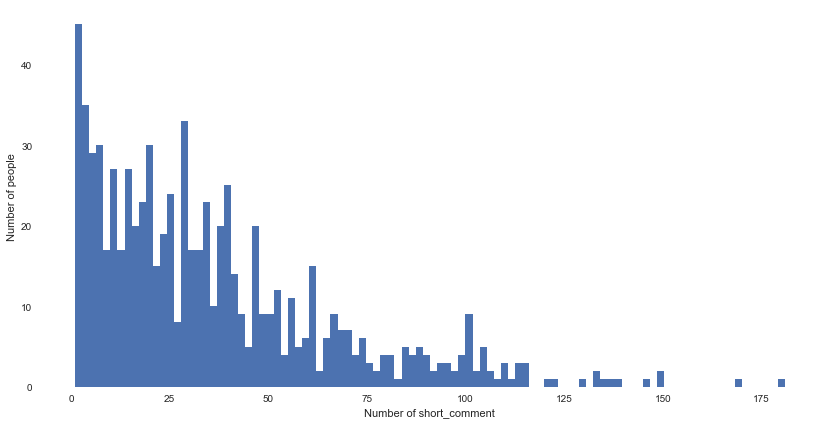

In [269]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

data_com_759.people.value_counts().hist(bins=100)
plt.ylabel('Number of people')
plt.xlabel('Number of short_comment')

In [378]:
# 取出评价过100次以上的短评小王子
coolpeo_list = data_com_759.people.value_counts()[data_com_759.people.value_counts() >=100].index.tolist()
# 短评小王子的短评
coolpeo_com = data_com_759[data_com_759.people.apply(lambda x: x in coolpeo_list)]
# 取出短评小王子评价过的电影
coolpeo_movie_id = coolpeo_com.movie_id.value_counts().index.tolist()
coolpeo_item = data_item[data_item.movie_id.apply(lambda x: x in coolpeo_movie_id)]
coolpeo_item_com = pd.merge(coolpeo_item, coolpeo_com, how='right' ,on='movie_id')
#“短评小王子”最爱评价的前十部电影
pd.DataFrame(coolpeo_item_com.movie_title.value_counts().head(10).values 
             ,index=coolpeo_item_com.movie_title.value_counts().head(10).index.values , columns = ['Num'])

,Num
肖申克的救赎 The Shawshank Redemption,42
千与千寻 千と千尋の神隠し,35
放牛班的春天 Les choristes,34
情书 Love Letter,34
勇敢的心 Braveheart,34
暖暖内含光 Eternal Sunshine of the Spotless Mind,34
阿甘正传 Forrest Gump,34
阳光灿烂的日子,33
美丽人生 La vita è bella,33
"两杆大烟枪 Lock, Stock and Two Smoking Barrels",32


In [379]:
pd.DataFrame(coolpeo_item_com.country.value_counts().head(10).values 
             ,index=coolpeo_item_com.country.value_counts().head(10).index.values , columns = ['Num'])

,Num
美国,1823
日本,535
香港,280
美国 / 德国,140
中国大陆 / 香港,123
美国 / 英国,115
英国 / 美国,110
英国,108
美国 / 加拿大,87
韩国,87


In [436]:
l = ['genre_剧情', 'genre_爱情', 'genre_喜剧', 'genre_科幻',
       'genre_动作', 'genre_悬疑', 'genre_犯罪', 'genre_恐怖', 'genre_青春', 'genre_励志',
       'genre_战争', 'genre_文艺', 'genre_黑色幽默', 'genre_传记', 'genre_情色',
       'genre_暴力', 'genre_音乐', 'genre_家庭']
data_item_com = pd.merge(data_item, data_com, how='right' ,on='movie_id')
for i in l:
    print(i[-2:], data_item_com[data_item_com[i] ==1].shape[0])

剧情 193436
爱情 61768
喜剧 49752
科幻 25558
动作 32853
悬疑 29719
犯罪 45810
恐怖 2060
青春 0
励志 0
战争 17099
文艺 0
幽默 0
传记 12418
情色 1040
暴力 0
音乐 7259
家庭 27877


In [437]:
# 数据准备 ================================================
data_X = data_item_com[data_item_com.genre_喜剧 ==1]
data_F = data_item_com[data_item_com.genre_犯罪 ==1]

import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

# 切词 ====================================================
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

sentences=[]
preprocess_text(data_X.content.dropna().values.tolist() ,sentences ,'喜剧')
preprocess_text(data_F.content.dropna().values.tolist() ,sentences ,'犯罪')
random.shuffle(sentences)       

# 切分训练集和测试集 ========================================
from sklearn.model_selection import train_test_split
x,y=zip(*sentences)
train_data,test_data,train_target,test_target=train_test_split(x, y, random_state=1234)

In [438]:
"""
基于卷积神经网络的中文文本分类
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

learn = tf.contrib.learn
FLAGS = None
# 文档最长长度
MAX_DOCUMENT_LENGTH = 100
# 最小词频数
MIN_WORD_FREQUENCE = 2
# 词嵌入的维度
EMBEDDING_SIZE = 20
# filter个数
N_FILTERS = 10 # 10个神经元
# 感知野大小
WINDOW_SIZE = 20
#filter的形状
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS] 
# 池化
POOLING_WINDOW = 4
POOLING_STRIDE = 2
n_words = 0

def cnn_model(features, target):
    """
    2层的卷积神经网络，用于短文本分类
    """
    # 先把词转成词嵌入
    # 我们得到一个形状为[n_words, EMBEDDING_SIZE]的词表映射矩阵
    # 接着我们可以把一批文本映射成[batch_size, sequence_length,EMBEDDING_SIZE]的矩阵形式
    target = tf.one_hot(target, 15, 1, 0) #对词编码
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    word_vectors = tf.expand_dims(word_vectors, 3)
    
    with tf.variable_scope('CNN_Layer1'):
        # 添加卷积层做滤波
        conv1 = tf.contrib.layers.convolution2d(word_vectors
                                                ,N_FILTERS
                                                ,FILTER_SHAPE1
                                                ,padding='VALID')
        # 添加RELU非线性
        conv1 = tf.nn.relu(conv1) 
        # 最大池化
        pool1 = tf.nn.max_pool(conv1
                               ,ksize=[1, POOLING_WINDOW, 1, 1]
                               ,strides=[1, POOLING_STRIDE, 1, 1]
                               ,padding='SAME')
        # 对矩阵进行转置，以满足形状
        pool1 = tf.transpose(pool1, [0, 1, 3, 2])
    with tf.variable_scope('CNN_Layer2'):
        # 第2卷积层
        conv2 = tf.contrib.layers.convolution2d(pool1
                                                ,N_FILTERS
                                                ,FILTER_SHAPE2
                                                ,padding='VALID') 
        # 抽取特征
        pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])
        
    # 全连接层
    logits = tf.contrib.layers.fully_connected(pool2, 15, activation_fn=None)
    loss = tf.losses.softmax_cross_entropy(target, logits) 
    # 优化器
    train_op = tf.contrib.layers.optimize_loss(loss
                                               ,tf.contrib.framework.get_global_step()
                                               ,optimizer='Adam'
                                               ,learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)

global n_words
# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE) 
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data)))
n_words=len(vocab_processor.vocabulary_) 
print('Total words:%d'%n_words)

cate_dic={'喜剧':0,'犯罪':1}
y_train = pd.Series(train_target).apply(lambda x:cate_dic[x] , train_target)
y_test = pd.Series(test_target).apply(lambda x:cate_dic[x] , test_target)

Total words:18613


In [439]:
# 构建模型
classifier=learn.SKCompat(learn.Estimator(model_fn=cnn_model))

# 训练和预测
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class'] 
score=metrics.accuracy_score(y_test,y_predicted) 
print('Accuracy:{0:f}'.format(score))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_save_summary_steps': 100, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x159628f98>, '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmp49oopogr', '_environment': 'local', '_num_worker_replicas': 0, '_num_ps_replicas': 0, '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_task_type': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmp49oopogr/model.ckpt.
INFO:tensorflow:step = 1, loss = 2.70988
INFO:tensorflow:global_step/sec: 9.64956
INFO:tensorflow:step = 101, loss = 0.696245 (10.365 sec)
INFO:tenso

In [441]:
def pred(commment):
    sentences=[]
    preprocess_text([commment] ,sentences, 'unknown')
    x,y=zip(*sentences)
    x_tt = np.array(list(vocab_processor.transform([x[0]])))
    
    if classifier.predict(x_tt)['class'][0]:
        print('犯罪片！')
    else:
        print('喜剧片！')

In [444]:
pred('太搞笑了！')

INFO:tensorflow:Restoring parameters from /var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmp49oopogr/model.ckpt-1000
喜剧片！


In [445]:
pred('罪有应得啊！')

INFO:tensorflow:Restoring parameters from /var/folders/g7/yj72g89x2mx2b1_r5zb22l940000gn/T/tmp49oopogr/model.ckpt-1000
犯罪片！
